This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import pymc as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np

from src.utils import *
from src.params import *
tqdm.pandas()

from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

# Data Pre-Processing

In [3]:
df, basin_idx, basins, coords = read_data(
    file_dir='../data/hierarchical_septics_v7.csv',
    cols=['ppt_2021', 'hydraulic_c','median_hse', 'slope', 'age_median', 'income_median'], 
    is_balanced=True, 
    hierarchy_type='county'
)

/Users/juannat/Documents/research/septic/bayesian_septic/notebooks/../src/utils.py:76: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir)


balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# VIF Analysis

In [4]:
vif_data = pd.DataFrame()
cluster_var = ['ppt_2021_norm', 'hydraulic_c_norm', 'median_hse_norm', 'slope_norm']
X = df[cluster_var]
vif_data['feature'] = cluster_var
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(cluster_var))]

In [5]:
vif_data

,feature,VIF
0,ppt_2021_norm,1.233285
1,hydraulic_c_norm,1.174369
2,median_hse_norm,1.211439
3,slope_norm,1.186037


# Hierarchical Bayesian Model

- Group septic systems based on their counties
- The effect of precipitation, soil characteristic, housing, topography to septic's system status
- Also add between-county fixed effects, including demographic age and income

In [4]:
rs = 100
tune = 100

1. Water model: precipitation and distance to water bodies

In [ ]:
# Modeling (water)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')
    income_d = pm.Data('income_d', df.income_median_norm.values, dims='septic')

    # global model parameters
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # similarity parameters
    similarity_c = pm.Normal('similarity_c', mu=0, sigma=10)
    income_mu = pm.Normal('income_mu', mu=0, sigma=10)
    ppt_mu = similarity_c + income_mu * income_d

    # septic-specific model parameters
    ppt = pm.Normal('ppt', mu=ppt_mu.mean(), sigma=ppt_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + ppt[basin] * ppt_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(rs, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.43135695180518 ± 0.06992667407027704%


2. Soil model

In [ ]:
# Modeling (soil)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    age_d = pm.Data('age_d', df.age_median_norm.values, dims='septic')
    income_d = pm.Data('income_d', df.income_median_norm.values, dims='septic')

    # global model parameters
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # similarity parameters
    similarity_c = pm.Normal('similarity_c', mu=0, sigma=10)
    age_mu = pm.Normal('age_mu', mu=0, sigma=10)
    income_mu = pm.Normal('income_mu', mu=0, sigma=10)
    hydr_mu = similarity_c + age_mu * age_d + income_mu * income_d

    # septic-specific model parameters
    hydr = pm.Normal('hydr', mu=hydr_mu.mean(), sigma=hydr_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hydr[basin] * hydr_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(rs, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1152 seconds.


In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.02726432072863 ± 0.004130928016592749%


3. Topo model: elevation/slope

In [ ]:
# Modeling (topo)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    # dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic') # dem
    slope_d = pm.Data('slope_d', df.slope_norm.values, dims='septic') # slope
    age_d = pm.Data('age_d', df.age_median_norm.values, dims='septic')
    income_d = pm.Data('income_d', df.income_median_norm.values, dims='septic')

    # global model parameters
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # similarity parameters
    similarity_c = pm.Normal('similarity_c', mu=0, sigma=10)
    slope_beta = similarity_c

    # septic-specific model parameters
    slope = pm.Exponential('slope', lam=slope_beta.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + slope[basin] * slope_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(rs, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_c, sigma_c, similarity_c, slope, c]


Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 2797 seconds.


In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 67.98045732253378 ± 0.022513091983295236%


4. Socio-economic model: median housing value

In [ ]:
# Modeling (socio)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    age_d = pm.Data('age_d', df.age_median_norm.values, dims='septic')
    income_d = pm.Data('income_d', df.income_median_norm.values, dims='septic')

    # global model parameters
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # similarity parameters
    similarity_c = pm.Normal('similarity_c', mu=0, sigma=10)
    age_mu = pm.Normal('age_mu', mu=0, sigma=10)
    income_mu = pm.Normal('income_mu', mu=0, sigma=10)
    hse_mu = similarity_c + age_mu * age_d + income_mu * income_d

    # septic-specific model parameters
    hse = pm.Normal('hse', mu=hse_mu.mean(), sigma=hse_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hse[basin] * hse_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(rs, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 1675 seconds.


In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 67.95259070706268 ± 0.02501546054987322%


5. Full model

In [5]:
# Modeling (full)
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    slope_d = pm.Data('slope_d', df.slope_norm.values, dims='septic')
    # dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')
    age_d = pm.Data('age_d', df.age_median_norm.values, dims='septic')
    income_d = pm.Data('income_d', df.income_median_norm.values, dims='septic')

    # global model parameters
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # similarity parameters
    ppt_similarity_c = pm.Normal('ppt_similarity_c', mu=0, sigma=10)
    hydr_similarity_c = pm.Normal('hydr_similarity_c', mu=0, sigma=10)
    slope_similarity_c = pm.Normal('slope_similarity_c', mu=0, sigma=10)
    hse_similarity_c = pm.Normal('hse_similarity_c', mu=0, sigma=10)

    ppt_income_mu = pm.Normal('ppt_income_mu', mu=0, sigma=10)
    ppt_mu = ppt_similarity_c + ppt_income_mu * income_d

    hydr_age_mu = pm.Normal('hydr_age_mu', mu=0, sigma=10)
    hydr_income_mu = pm.Normal('hydr_income_mu', mu=0, sigma=10)
    hydr_mu = hydr_similarity_c + hydr_age_mu * age_d + hydr_income_mu * income_d

    slope_beta = slope_similarity_c

    hse_age_mu = pm.Normal('hse_age_mu', mu=0, sigma=10)
    hse_income_mu = pm.Normal('hse_income_mu', mu=0, sigma=10)
    hse_mu = hse_similarity_c + hse_age_mu * age_d + hse_income_mu * income_d

    # septic-specific model parameters
    ppt = pm.Normal('ppt', mu=ppt_mu.mean(), sigma=ppt_sig, dims='basin')
    hydr = pm.Normal('hydr', mu=hydr_mu.mean(), sigma=hydr_sig, dims='basin')
    hse = pm.Normal('hse', mu=hse_mu.mean(), sigma=hse_sig, dims='basin')
    slope = pm.Exponential('slope', lam=slope_beta.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + slope[basin] * slope_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(rs, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 68.58255885689267 ± 0.039964889004643775%


In [ ]:
# from graphviz import Source
# filename='../docs/single_level_with_attributes'
# graph = Source.from_file(filename)
# graph.render(filename=filename, )

'../docs/single_level_with_attributes.pdf'

# Evaluation

In [ ]:
import geopandas as gpd

boundary_file = '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'
state_fp = '13'

# Read county information
bdry = gpd.read_file(boundary_file)
state_bdry = bdry[bdry['STATEFP'] == state_fp].reset_index(drop=True)
state_bdry['NAME'] = state_bdry['NAME'].str.upper()

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


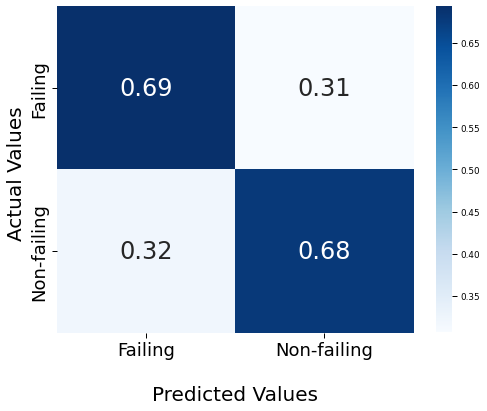

In [ ]:
plot_confusion(y, y_pred, title='', savedir='../docs/confusion_l1.pdf')

In [ ]:
# Draw parameters from posterior stack at each basin
drivers = [
    'ppt', 'hydr', 'hse', 'slope', 'c', 
    'ppt_similarity_c', 'ppt_income_mu', 
    'hydr_similarity_c', 'hydr_age_mu', 'hydr_income_mu', 
    'slope_similarity_c',
    'hse_similarity_c', 'hse_age_mu', 'hse_income_mu'
]
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))
basin_params = hier_post[drivers].mean(dim='chain_draw').to_pandas().reset_index().rename(columns={'basin':'NAME'})

# Join on basin names
basin_params = state_bdry.merge(basin_params, on='NAME', how='left')
basin_params = basin_params.merge(
    df.groupby(['tblSGA_Property.county_property']).mean().reset_index().rename(columns={'tblSGA_Property.county_property':'NAME'}), 
    on='NAME', how='left')

basin_params.to_csv('../tmp/basin_params_with_attributes_v2.csv')

## Parameter distribution

In [ ]:
drivers = [
    'ppt', 'hydr', 'hse', 'slope', 'c'
]

# Draw parameters from posterior stack at each county
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))
basin_params = hier_post[drivers].mean(dim='chain_draw').to_pandas().reset_index().rename(columns={'basin':'NAME'})

# Join on basin names
basin_params = state_bdry.merge(basin_params, on='NAME', how='left')

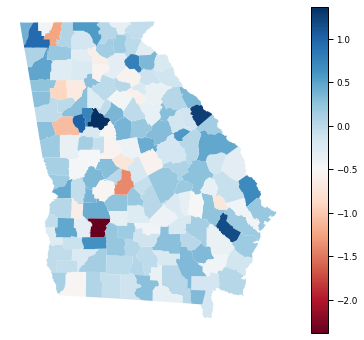

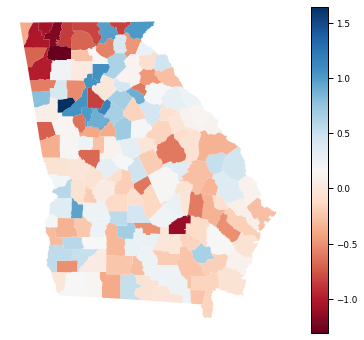

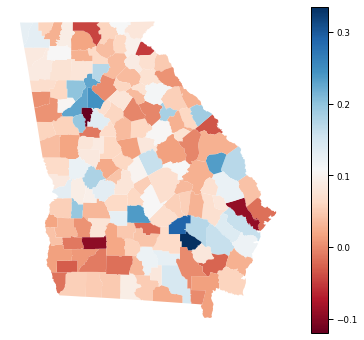

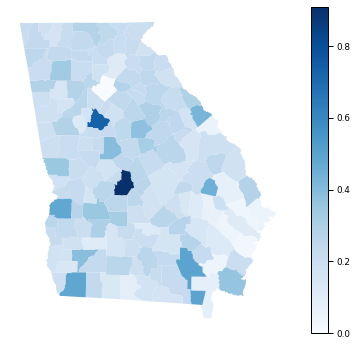

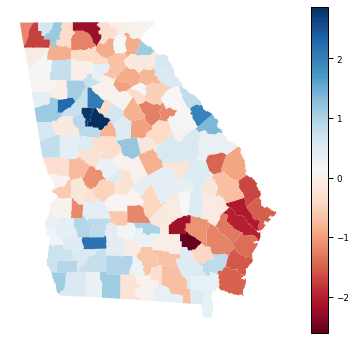

In [ ]:
# Plot for each determinant
basin_params = basin_params.fillna(0)
for driver in drivers:
    f, ax = plt.subplots(figsize=(8,6))
    if driver == 'slope':
        basin_params.plot(column=driver, ax=ax, legend=True, cmap='Blues')
    else:
        basin_params.plot(column=driver, ax=ax, legend=True, cmap='RdBu')
    ax.axis('off')
    f.savefig(f'../docs/posterior_{driver}.pdf', dpi=300, bbox_inches='tight')

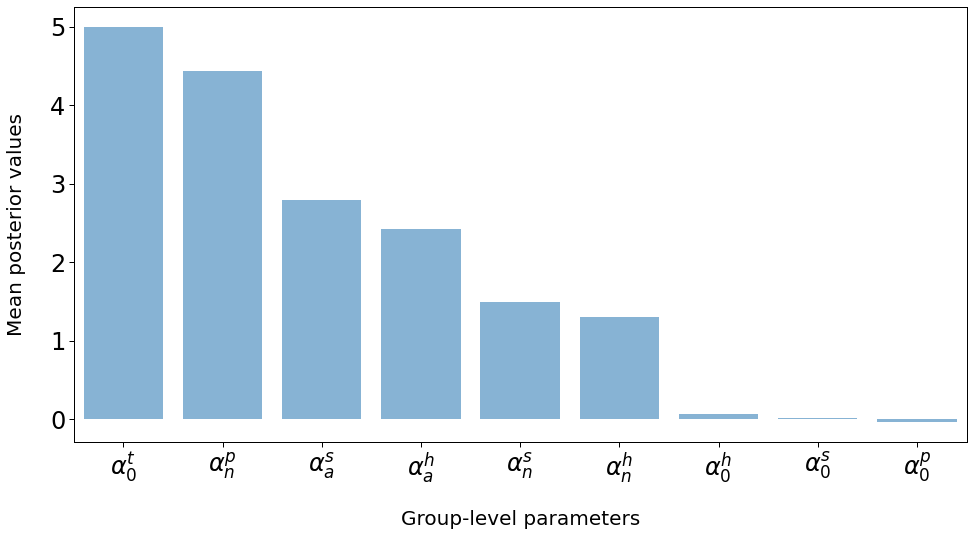

In [ ]:
# plot statistics for group-level parameters
drivers = [
    'ppt_similarity_c', 'ppt_income_mu', 
    'hydr_similarity_c', 'hydr_age_mu', 'hydr_income_mu', 
    'slope_similarity_c',
    'hse_similarity_c', 'hse_age_mu', 'hse_income_mu'
]

# Draw parameters from posterior stack at each county
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))
mean = hier_post[drivers].mean(dim='chain_draw').to_pandas().values
std = hier_post[drivers].std(dim='chain_draw').to_pandas().values
group_post_df = pd.DataFrame({'mean': mean, 'std': std}, index=drivers)
group_post_df = group_post_df.reset_index().rename(columns={'index':'Parameters'})
group_post_df['Parameters'] = [r"$\alpha^p_0$", r"$\alpha^p_n$", 
                               r"$\alpha^s_0$", r"$\alpha^s_a$", r"$\alpha^s_n$",
                               r"$\alpha^t_0$",
                               r"$\alpha^h_0$", r"$\alpha^h_a$", r"$\alpha^h_n$"
                               ]

f, ax = plt.subplots(figsize=(16,8))
sns.barplot(x='Parameters', y='mean', data=group_post_df, facecolor='#87b3d4' , ax=ax, order=group_post_df.sort_values('mean', ascending=False).Parameters)
ax.set_xlabel("Group-level parameters", labelpad = 24, fontsize=20)
ax.set_ylabel("Mean posterior values", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=24);
f.savefig(f'../docs/posterior_group.pdf', dpi=300, bbox_inches='tight')

## Prediction skill

In [ ]:
# Compute prediction on individual system
y = df.sewageSystem_enc.to_list()
accs = list()
acc, y_pred = evaluate_bayes(trace, model, y)

pred_outcome, false_pos, false_neg = list(), list(), list()
for true, pred in zip(y, y_pred):
    # Overall skill
    if true == pred: 
        pred_outcome.append(True)
    else: 
        pred_outcome.append(False)

    # False positives
    if true == 0. and pred == 1.: 
        false_pos.append(True)
    else:
        false_pos.append(False)
    
    # False negatives
    if true == 1. and pred == 0.:
        false_neg.append(True)
    else:
        false_neg.append(False)

# Get the average skill per basin/county
pred_df = df
pred_df['correct_pred'] = pred_outcome
pred_df['false_pos'] = false_pos
pred_df['false_neg'] = false_neg
pred_df = df.groupby(by='tblSGA_Property.county_property').mean().reset_index().rename(columns={'tblSGA_Property.county_property': 'NAME'})

# Join on basin names
basin_pred = state_bdry.merge(pred_df, on='NAME', how='left')

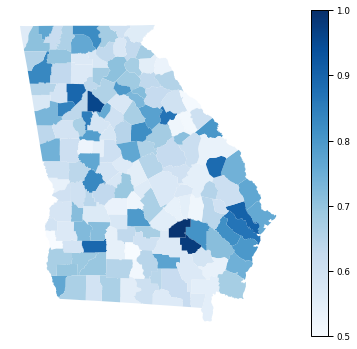

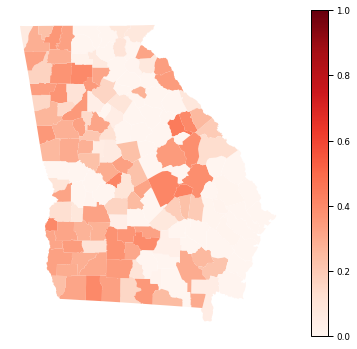

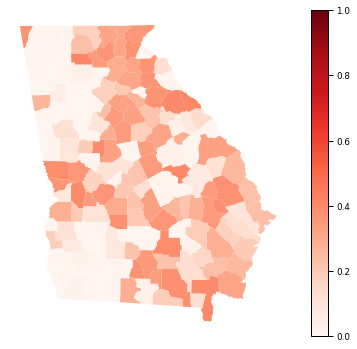

In [ ]:
# Plot for each parameter
acc_stats = ['correct_pred', 'false_pos', 'false_neg']
for acc_stat in acc_stats:
    basin_pred[acc_stat] = basin_pred[acc_stat].fillna(basin_pred[acc_stat].mean())
    f, ax = plt.subplots(figsize=(8,6))
    if acc_stat.startswith('false'):
        basin_pred.plot(column=acc_stat, ax=ax, legend=True, vmin=0, vmax=1, cmap='Reds')
    else:
        basin_pred.plot(column=acc_stat, ax=ax, legend=True, vmin=0.5, vmax=1, cmap='Blues')
    ax.axis('off');
    f.savefig(f'../docs/hb_skill_{acc_stat}.pdf', dpi=300, bbox_inches='tight')

## Pooled Posterior Distribution

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=['ppt', 'hydr', 'hse', 'slope', 'failures'], random_seed=rs
    )

In [ ]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

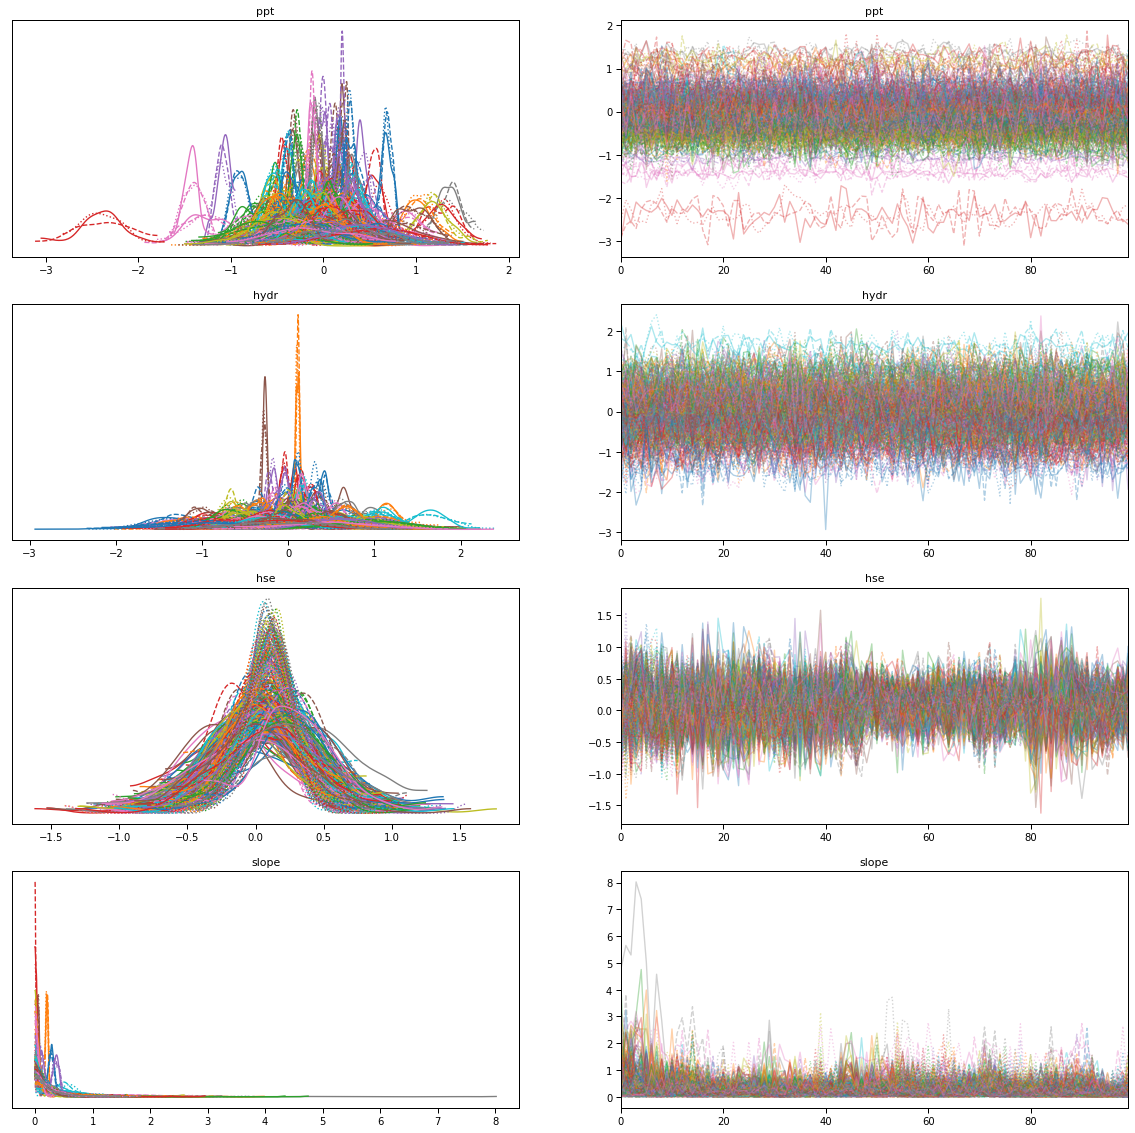

In [ ]:
import arviz as az
axes = az.plot_trace(trace, var_names=['ppt', 'hydr', 'hse', 'slope'], divergences=None, figsize=(20,20))
f = axes.ravel()[0].figure
f.savefig('../docs/posterior_distribution.pdf', bbox_inches='tight')

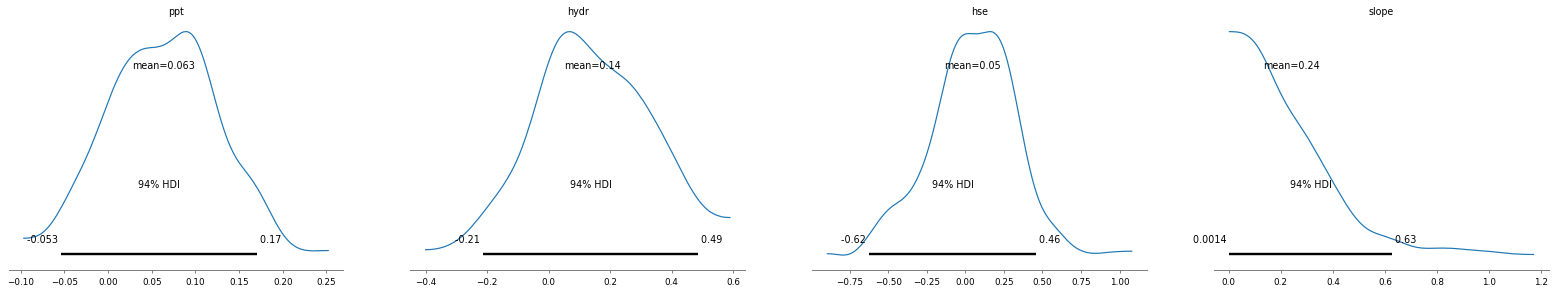

In [ ]:
az.plot_posterior(trace, var_names=['ppt', 'hydr', 'hse', 'slope'], coords={"basin": "GRADY"});

## Posterior Variance Check

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=['ppt', 'hydr', 'hse', 'slope', 'failures']
    )

In [ ]:
# Compute aprior and fitted posterior SD
var_dict = {'ppt': 10, 'hydr': 10, 'hse': 10, 'slope': 10}
post_init_var = []
post_fit_var = []
for param, var in var_dict.items():
    # post_init_var.append(round(np.sqrt(full_priors[param].var()), 2))
    post_init_var.append(var_dict[param])
    post_fit_var.append(round(np.sqrt(ppc['posterior_predictive'][param].mean(axis=(0,1)).var().item()), 2))

init_var_df = pd.DataFrame({'Params': var_dict.keys(), 'SD': post_init_var, 'Parameter': 'Prior'})
fit_sig_df = pd.DataFrame({'Params': var_dict.keys(), 'SD': post_fit_var, 'Parameter': 'Fitted'})

sig_df = pd.concat([init_var_df, fit_sig_df])

/var/folders/3_/bdv8r_590xz8hvrnflbd7dxm0000gn/T/ipykernel_2359/1989931276.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error in 3.6
  f.savefig('../docs/posterior_var.pdf', dpi=300, bbox_inces='tight')


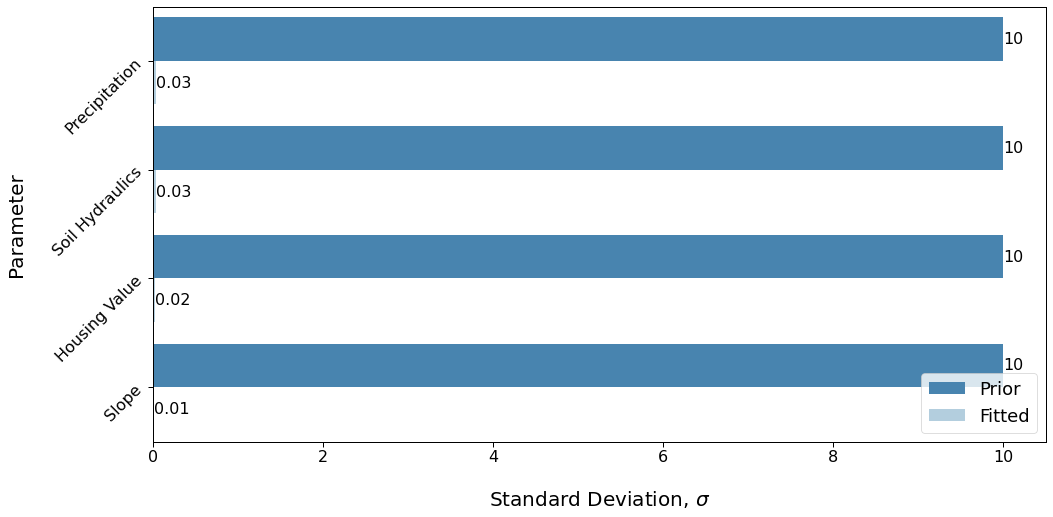

In [ ]:
# Plotting
f, ax = plt.subplots(figsize=(16, 8))
ax = sns.barplot(x='SD', y='Params', hue='Parameter', data=sig_df, palette='Blues_r', orient='h')
# ax.set_title('SD for Priori and Fitted Posterior', size=16)
ax.set_xlabel('Standard Deviation, $\sigma$', labelpad = 24, fontsize=20)
ax.set_ylabel('Parameter', labelpad = 24, fontsize=20)
labels = ['Precipitation', 'Soil Hydraulics', 'Housing Value', 'Slope']
ax.set_yticklabels(labels)
ax.tick_params(labelsize=16)
plt.legend(fontsize=18, loc='lower right')
plt.yticks(rotation = 45)
for i in ax.containers:
    ax.bar_label(i,size=16)

f.savefig('../docs/posterior_var.pdf', dpi=300, bbox_inces='tight')